# Project Deliverable 3 - Group 33
#### Group Members: Bethany Findlay, Charlotte Albert, Kaykay Akpama, Kosi Udechukwu

## Notebook Set-Up

In [4]:
#Import necessary libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import metrics
from sklearn import inspection
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
#Read cleaned data from past project deliverables
df=pd.read_csv("project_deliverable_1_cleaned.csv")

In [6]:
# Same feature engineering from deliverable 2
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_time_fractional'] = df['pickup_hour'] + df['pickup_minute'] / 60

day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['pickup_day_num'] = df['pickup_day'].map(day_mapping)

## 1. Full Pipeline Construction

In [7]:
# Defining the feature set, using the expanded feature set from Deliverable 2

numeric_features = [
    'trip_distance_km',
    'pickup_day_num',
    'pickup_hour',
    'pickup_minute',
    'pickup_time_fractional',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
]

target = 'trip_duration'

In [8]:
# preprocessing with ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

StandardScaler puts all numeric features on a similar scale, helping models train more effectively. The ColumnTransformer is used so the preprocessing steps apply only to the selected numeric columns. This keeps the workflow clear and ensures the same steps are used during both training and testing.

In [9]:
# building 2 model pipelines (KNN Regression & Linear Regression)
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

knn_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=10))
])

The two model families selected for comparison are Linear Regression and KNN Regression, similarly to deliverable 2. Linear Regression provides a simple baseline model that is fast and easy to interpret. KNN Regression captures more complex patterns by looking at nearby datapoints.

In [10]:
# train/test split
X = df[numeric_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# fit and evaluate with RMSE, MAE, R^2
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

linreg_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

linreg_metrics = evaluate(linreg_model, X_test, y_test)
knn_metrics = evaluate(knn_model, X_test, y_test)

The evaluation function uses MAE, RMSE, and R^2 because these three metrics give an overall view of the model performance for a regression task. MAE shows the average size of errors, RMSE penalizes larger mistakes more strongly, and R^2 shows how much the variation in trip duration the model can explain. Multiple metrics helps to compare multiple models against one another.

In [12]:
# print results for comparison
print("Linear Regression Results:")
print(f"MAE: {linreg_metrics[0]:.3f} secs")
print(f"RMSE: {linreg_metrics[1]:.3f} secs")
print(f"R^2: {linreg_metrics[2]:.3f}\n")

print("KNN Regression Results:")
print(f"MAE: {knn_metrics[0]:.3f} secs")
print(f"RMSE: {knn_metrics[1]:.3f} secs")
print(f"R^2: {knn_metrics[2]:.3f}")

Linear Regression Results:
MAE: 276.784 secs
RMSE: 407.309 secs
R^2: 0.604

KNN Regression Results:
MAE: 199.656 secs
RMSE: 316.123 secs
R^2: 0.761


## 2. Systematic Hyperparameter Tuning

### Principle Component Analysis
PCA is a linear dimensionality reduction techinque used to reduce the number of features in the dataset while still maintaining patterns or variance between features. KNN can suffer from the curse of dimensionality when given too many features and is quite computationally expensive when calculating the distances between all the points: this can be solved with PCA. 

In [13]:
#Create a pipeline for the PCA test
pca_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA()),
    ("knn", KNeighborsRegressor(n_neighbors = 10))
])

In [14]:
#Test the model with 2, 4, 6, and 8 principal components
pca_param_grid = {
    "pca__n_components": [2, 4, 6, 8],
}

#Define scoring metrics
scoring = {
    "r2": "r2",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error"
}

In [15]:
#Perform GridSearchCV to find the best number of principal components
knn_tuning_pca = GridSearchCV(pca_test_pipeline, pca_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_pca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=10))]),
             n_jobs=-1, param_grid={'pca__n_components': [2, 4, 6, 8]},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [16]:
results_pca = pd.DataFrame(knn_tuning_pca.cv_results_)
show_pca = results_pca[[
    'param_pca__n_components',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_pca)

   param_pca__n_components  mean_test_r2  std_test_r2  \
0                        2      0.496397     0.001423   
1                        4      0.540889     0.001372   
2                        6      0.642717     0.001296   
3                        8      0.758019     0.001844   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -324.403617                          0.891380   
1                        -308.025059                          0.593749   
2                        -264.329273                          0.564104   
3                        -201.856211                          0.353111   

   mean_test_neg_root_mean_squared_error  \
0                            -461.301273   
1                            -440.449864   
2                            -388.549917   
3                            -319.766580   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.263628             4  
1         

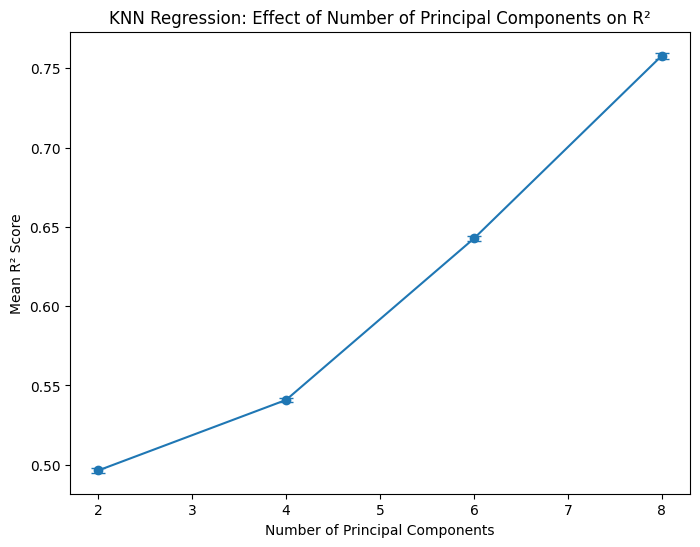

In [17]:
x_pca = results_pca["param_pca__n_components"]
y_pca = results_pca["mean_test_r2"]
y_err_pca = results_pca["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_pca, y_pca, yerr=y_err_pca, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Number of Principal Components on R²")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean R² Score")
plt.show()

PCA = 8 was the best performer across the board. It does have the largest standard deviation for R^2, but it is very negligible: PC = 6 has a std of 0.0012 while PC = 8 has a std of 0.0018. However, when comparing the MAE, RMSE, and R^2 with the results from above, the model performs best with no PCA applied. This is because are not a significant amount of features in the dataset for the curse of dimensionality to be a factor, for 1,458,644 records there are only 9 input features.

### Nearest Neighbors
The main hyperparameter in KNN is the number of nearest neighbors. This metric designates how many of the closest data points the model will consider when taking the average to make a prediction. In deliverable 2, it was found that 10 neighbors performed better than 5. Using more neighbors can help the model prevent overfitting. 

In [18]:
#Create a pipeline for the n_neighbors test
nneighbors_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

In [19]:
#Test the model with 10, 15, 20, and 25 neighbors
nneighbors_param_grid = {
    "knn__n_neighbors": [10, 15, 20, 25]
}

In [20]:
#Perform GridSearchCV to find the best number of neighbors
knn_tuning_nneighbors = GridSearchCV(nneighbors_test_pipeline, nneighbors_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_nneighbors.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': [10, 15, 20, 25]},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [21]:
results_nneighbors = pd.DataFrame(knn_tuning_nneighbors.cv_results_)
show_nneighbors = results_nneighbors[[
    'param_knn__n_neighbors',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_nneighbors)

   param_knn__n_neighbors  mean_test_r2  std_test_r2  \
0                      10      0.758019     0.001844   
1                      15      0.761444     0.001837   
2                      20      0.762244     0.001753   
3                      25      0.762012     0.001823   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -201.856211                          0.353111   
1                        -200.118627                          0.389410   
2                        -199.749683                          0.379913   
3                        -199.948196                          0.386796   

   mean_test_neg_root_mean_squared_error  \
0                            -319.766580   
1                            -317.496028   
2                            -316.962878   
3                            -317.117782   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.481206             4  
1              

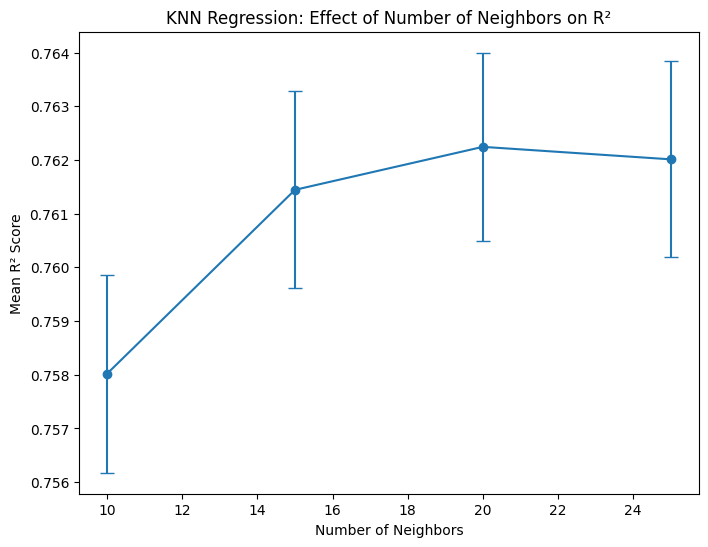

In [22]:
x_nneighbors = results_nneighbors["param_knn__n_neighbors"]
y_nneighbors = results_nneighbors["mean_test_r2"]
y_err_nneighbors = results_nneighbors["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_nneighbors, y_nneighbors, yerr=y_err_nneighbors, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Number of Neighbors on R²")
plt.xlabel("Number of Neighbors")
plt.ylabel("Mean R² Score")
plt.show()

Here we can see that 20 nearest neighbors performs the best across the board. This is likely because its preventing overfitting on the training data, and thus performs better on the data it hasn't seen. It should be noted that the standard deviation from MAE is only the second lowest while nneighbors = 10 has the lowest. However, for all other standard deviations it has the lowest scores.

### Weights
Now, another metric to adjust in KNN is the weighting metric. There are two options: uniform and metic. Uniform will give equal weight to all neighbors within the range. Distance will give more weight to closer neighbors. Distance versus uniform is a direct correlation to the bias versus variance tradeoff. The uniform weighting will reduce variance but increase bias and the distance weighting will reduce bias but increase variance.

It should be noted that previously in deliverable 2, the weights = distance made the train RMSE 0, this is because when training the model considers the distance from itself, and thus will perform "perfectly" on the training data. The more accurate measurement is on the performance when considering the test data. 

In [23]:
#Create a pipeline for the weights test
weights_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=20))
])

In [24]:
#Test the model with uniform versus distance weighting
weights_param_grid = {
    "knn__weights": ["uniform", "distance"]
}

In [25]:
#Perform GridSearchCV to find the best number weighting method
knn_tuning_weights = GridSearchCV(weights_test_pipeline, weights_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_weights.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=20))]),
             n_jobs=-1, param_grid={'knn__weights': ['uniform', 'distance']},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [26]:
results_weights = pd.DataFrame(knn_tuning_weights.cv_results_)
show_weights = results_weights[[
    'param_knn__weights',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_weights)

  param_knn__weights  mean_test_r2  std_test_r2  \
0            uniform      0.762244     0.001753   
1           distance      0.764605     0.001811   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -199.749683                          0.379913   
1                        -198.341127                          0.374711   

   mean_test_neg_root_mean_squared_error  \
0                            -316.962878   
1                            -315.385014   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.419417             2  
1                              2.457451             1  


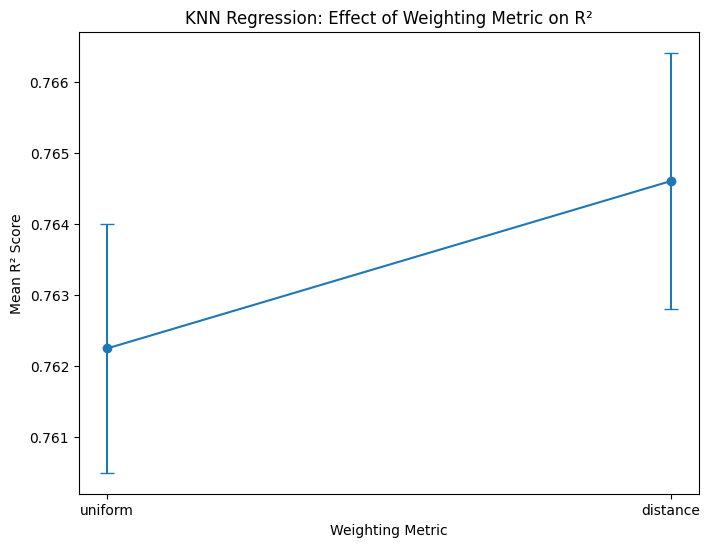

In [27]:
x_weights = results_weights["param_knn__weights"]
y_weights = results_weights["mean_test_r2"]
y_err_weights = results_weights["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_weights, y_weights, yerr=y_err_weights, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Weighting Metric on R²")
plt.xlabel("Weighting Metric")
plt.ylabel("Mean R² Score")
plt.show()

Across the board, the distance weights performed better. This is likely because the model can make more accurate predictions. With the number of neighbors being 20, if the weights are uniform, the model could be considering a point that is far away. The distance weighting helps solve that problem by giving more recognition to closer points. Uniform weighting does give lower standard deviations, but the differences are extremely small. 

In [28]:
#Build a simple, interpretable baseline model in scikit-learn
base_features=['trip_distance_km','pickup_hour','pickup_day_num']
target='trip_duration'
y = df[target]
X_base = df[base_features]

knn_pipe_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 5))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

knn_baseline_results = cross_validate(
    knn_pipe_baseline,
    X_base,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

cv_table_knn_baseline = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_baseline_results['test_r2']))],
    'R^2 Score': knn_baseline_results['test_r2'],
    'MAE (s)': -knn_baseline_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_baseline_results['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_baseline_results['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_baseline_results['test_neg_root_mean_squared_error']
})

In [29]:
#Pipeline, cross validation and results DataFrame for KNN with new features
knn_tuned_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 20, weights='distance'))
])

knn_tuned_results = cross_validate(
    knn_tuned_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

cv_table_knn_tuned = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_tuned_results['test_r2']))],
    'R^2 Score': knn_tuned_results['test_r2'],
    'MAE (s)': -knn_tuned_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_tuned_results['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_tuned_results['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_tuned_results['test_neg_root_mean_squared_error']
})

In [30]:
#Extract metrics for all models
r2_knn_baseline = knn_baseline_results['test_r2']
mae_knn_baseline = -knn_baseline_results['test_neg_mean_absolute_error']
mse_knn_baseline = -knn_baseline_results['test_neg_mean_squared_error']
rmse_test_knn_baseline = -knn_baseline_results['test_neg_root_mean_squared_error']

r2_knn_tuned = knn_tuned_results['test_r2']
mae_knn_tuned = -knn_tuned_results['test_neg_mean_absolute_error']
mse_knn_tuned = -knn_tuned_results['test_neg_mean_squared_error']
rmse_test_knn_tuned = -knn_tuned_results['test_neg_root_mean_squared_error']

#Create comparison DataFrame for all models
comparison_df_base_vs_tuned = pd.DataFrame({
    'Metric': ['R^2', 'MAE (s)', 'MSE (s^2)', 'test RMSE (s)'],
    'KNN Baseline Model' : [r2_knn_baseline.mean(), mae_knn_baseline.mean(), mse_knn_baseline.mean(), rmse_test_knn_baseline.mean()],
    'KNN Tuned Model' : [r2_knn_tuned.mean(), mae_knn_tuned.mean(), mse_knn_tuned.mean(), rmse_test_knn_tuned.mean()]
})

print('KNN Regression: Baseline versus Tuned Model Comparion')
comparison_df_base_vs_tuned

KNN Regression: Baseline versus Tuned Model Comparion


,Metric,KNN Baseline Model,KNN Tuned Model
0,R^2,0.656609,0.767659
1,MAE (s),252.575649,196.536231
2,MSE (s^2),144841.279789,98004.953943
3,test RMSE (s),380.575532,313.048845


The comparison of the tuned model and the baseline show a significant difference for all evaluation metrics. The R^2 goes up by a little over 10%, MAE decreases by 55 seconds, MSE decreases by 46,863 seconds^2, and RMSE decreases by almost 70 seconds.

## 3. Final Model Selection and Evaluation

In [31]:
#Show results for final cross-validated performance for k=20 and weights ='distance'
print("Final Cross-Validated Performance (KNN, k=20, weights='distance')\n")
print(f"R²:   {r2_knn_tuned.mean():.3f}")
print(f"MAE:  {mae_knn_tuned.mean():.2f}")
print(f"MSE:  {mse_knn_tuned.mean():.2f}")
print(f"RMSE: {rmse_test_knn_tuned.mean():.2f}")

Final Cross-Validated Performance (KNN, k=20, weights='distance')

R²:   0.768
MAE:  196.54
MSE:  98004.95
RMSE: 313.05


KNN with distance weighting and k=20 was selected as the final model due to its strong cross-validated R² and relatively low MAE/RMSE, outperforming alternative models considered during tuning. The final values for the R², MAE, MSE and RMSE can be found in the results above. The results indicate that the tuned model explains approximately 76.8% of the variance in the trip duration; this shows a strong overall fit. The MAE and RMSE are reasonably low, although the higher RMSE suggests the presence of some larger errors (likely on long or unusual trips), as confirmed in the residual plot.

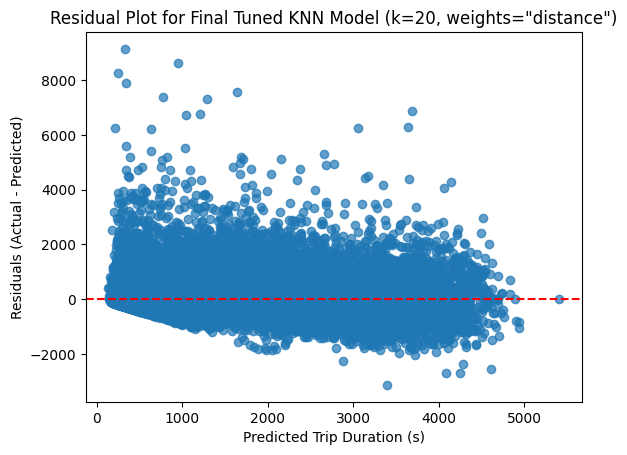

In [32]:
# Fit and predict using the tuned pipeline and show residual plot 
knn_tuned_pipe.fit(X_train, y_train)
y_pred = knn_tuned_pipe.predict(X_test)

res = y_test - y_pred

plt.scatter(y_pred, res, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Trip Duration (s)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Final Tuned KNN Model (k=20, weights="distance")')
plt.show()



A residual plot was chosen as the diagnostic visualization because it can provide helpful information about our data, given that this is a regression task aimed at predicting continuous trip duration. The residual plot shows randomly distributed points above and below the line and no pattern between prediction errors and predicted values, indicating good accuracy.However, the residuals become more spread out for longer predicted trip durations. This means that the prediction errors are less consistent and tend to vary more for those longer or less typical trips

To better understand the model’s performance, it's important to examine the error patterns and limitations of KNN. A downfall of KNN is that because it relies mainly on proximity in feature spaces, predictions of model behavior depend on how similar a new trip is to previously seen trips. When there are few comparable examples (e.g., very long or very short trips), the model doesn't have much to work with, so its accuracy decreases. Additionally, KNN can be computationally expensive for large datasets, as it must compute distances to all training samples for every new prediction. Another limitation is that KNN lacks direct interpretability: it cannot explain why a specific prediction was made or which features had the most significant influence. Moreover, since KNN is sensitive to feature scaling and noise, any outliers or uneven data distribution may introduce bias into the results. 

In conclusion, while the model captures nonlinear patterns, it tends to underperform on rare or extreme cases, highlighting the need for further improvements like feature engineering to boost generalization.


## 4. Integration of TA Feedback

The TA’s feedback highlighted several strengths in our earlier work, including our justification for using KNN as a baseline model, our clear implementation of cross-validation, and the overall organization and documentation of the notebook. The main suggestion for improvement was to provide deeper explanations for our diagnostic plots, particularly in relation to class imbalance, bias, and variance. In response, we expanded our diagnostics section by adding clearer interpretations of what each plot reveals about model performance and how these insights influenced our tuning choices.

The TA also noted that our discussion of improvements and generalization was thoughtful, so we strengthened this by more explicitly connecting observed model behaviour to the adjustments we made. We refined our final model selection section to better highlight the evidence behind our decision and clarified the trade-offs between the models compared. Additionally, we enhanced the structure and clarity of our methodology to maintain the strong notebook quality recognized in the feedback. Overall, this deliverable incorporates all TA comments and demonstrates clear progression from the previous stage.

## 5. Final Reflection

Our team learned how to apply key data analysis steps, from cleaning the dataset to building and evaluating models. We also gained a better understanding of how statistical techniques guide decision-making. One of the main challenges was interpreting the results accurately, but it was rewarding to see our work come together in a meaningful way. If we had more time, we would improve our model by testing additional features or trying more advanced methods, because this could increase accuracy and give deeper insights into the data.

## 6. Individual Contributions

Bethany Findlay: Full Pipeline Construction (Preprocessing + Model)

Charlotte Albert: Systematic Hyperparameter Tuning

Kaykay Akpama: Final Model Selection and Evaluation

Kosi Udechukwu: Integration of TA Feedback; Final Reflection

## BONUS: Kaggle Submission

The Kaggle Competition for the New York City Taxi Trip Duration competition evaluations based on RMSLE (root mean squared logarithmic error). Throughout this project, our team did not evaluate on this metric, but to make an accurate comparison, RMSLE is calculated on our internal evaluation below.

In [37]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

y_pred_test = knn_tuned_pipe.predict(X_test)

rmsle_value = rmsle(y_test, y_pred_test)
print("RMSLE:", rmsle_value)

RMSLE: 0.3727541767838965


As seen above, the internal evaluation showed an RMSLE of 0.3728, indicating that the tuned KNN model fit the data well. On the Kaggle hidden test set, the model achieved an RMSLE of 0.4783, which is higher, but still a reasonable score. This gap suggests some distribution shift between our processed dataset and the actual Kaggle test data, as well as potential limitations of KNN while generalizing to unseen data. Overall, these scores show the model maintains reasonable performance, though it does not generalize as strongly as the cross-validation results initally suggested. 

The results from the Kaggle evaluation can be seen in the screenshot included in the submission.